<h1 style='text-align: center;'> Independent Natural Language Processing Project 2 </h1> 
<h3 style='text-align: center;'> By Sri Das </h3>

<h2 style='text-align: center;'> Twitter data classification </h2>

### Importing packages

In [1]:
# Generic 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# NLP packages

import re, string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [117]:
# Modeling related packages

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score, recall_score 
from sklearn.pipeline import Pipeline
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

### Loading and exploring data

In [4]:
data = pd.read_csv('tweet_data.csv')

In [5]:
data.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,photoUrl,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,videoUrl
0,1070867471245164544,2018-12-07 02:27:55,-1,-1,98,False,True,False,64,https://pbs.twimg.com/media/Dtx8SiIWkAImVsb.jpg,34,-1,The immediate impulse for an alliance of the E...,Business,23464532,5988062,The Economist,NaN
1,1070868017888837633,2018-12-07 02:30:05,-1,-1,13,False,True,False,10,https://pbs.twimg.com/media/Dtx8yTyW4AEciqP.jpg,3,-1,America's economy is flashing some warning sig...,Business,1732809,16184358,CNN Business,NaN
2,1070868012864028673,2018-12-07 02:30:04,-1,-1,12,False,True,False,8,NaN,4,-1,Lyft files for what is expected to be one of t...,Business,2253989,25053299,FORTUNE,NaN
3,1070867995239555075,2018-12-07 02:30:00,-1,-1,5,False,True,False,4,NaN,1,-1,"Exporters still waiting to get Rs 6,000 crore ...",Business,1704056,43855487,Business Standard,NaN
4,1070867995205885952,2018-12-07 02:30:00,-1,-1,5,False,True,False,2,NaN,3,-1,Ride-hailing firm Lyft races to leave Uber beh...,Business,1997662,15110357,Reuters Business,https://video.twimg.com/amplify_video/10708116...


In [6]:
data.shape

(785916, 18)

Checking and removing null values

In [7]:
data.isna().sum()

tweetID            0
crDate             0
edInput            0
editor             0
engages            0
isApproved         0
isEdNeed           0
isRT               0
likes              0
photoUrl      508020
retweets           0
rtUsID             0
text               0
topicName          0
usFlwrs            0
usID               0
usName             0
videoUrl      645425
dtype: int64

Most entries of features 'photourl' and 'videourl' are null values, so removing these columns from the data

In [7]:
data.dropna(axis='columns', inplace=True)

The description of data mentioned that a value of 1 for 'edInput' indicate correct classification of the data and 'edInput' value of 2 is incorrect classification of the data. So slicing the data based on these two values for further analysis. We will use text of the tweet as a feature and the 'topicName' as target variable. 

In [8]:
data_1 = (data[(data['edInput'] == 1) | (data['edInput'] == 2)]).copy(deep=True)

In [9]:
data_1.reset_index(drop=True, inplace=True)

Mapping the 'topicName' to variable 'target' with numbers. 'target' is assigned 1 if topic of the tweet is 'Business' else it is assigned a 0.

In [10]:
data_1['target'] = 0
data_1.loc[data_1.topicName == 'Business', 'target'] = 1

The number of tweets related to the topic 'Business' are 30024 and rest of the topics are 292294


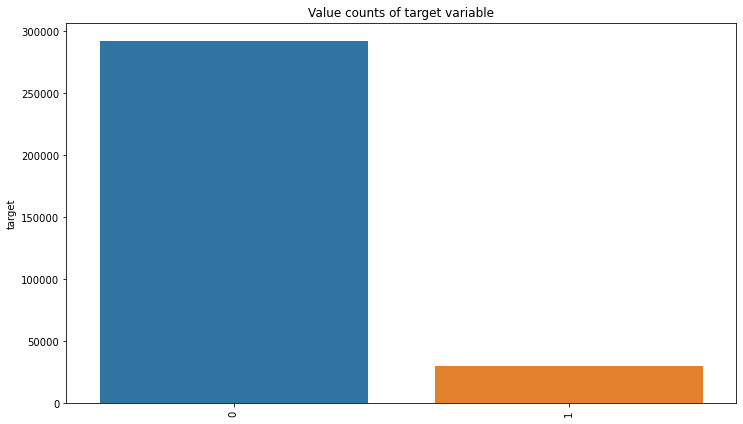

In [11]:
# Plotting the target values 

tar = data_1['target'].value_counts()
plt.figure(figsize = (12, 7))
plt.title('Value counts of target variable')
sns.barplot(x=tar.index, y=tar)
plt.xticks(rotation=90);

print("The number of tweets related to the topic 'Business' are {} and rest of the topics are {}".format(tar[1], tar[0]))

The above figure shows that the data is heavily imbalanced, as business related tweets are about 9% of our dataset. Any model we build to classify the tweets will be biased due to this disparity. Techniques to circumvent the effects of imbalanced data and also the metrics we can use to assess the model performance will be discussed later

#### Word count of the tweets

In [12]:
data_1['word_count'] = data_1['text'].apply(lambda x: len(str(x).split()))
print('Average word count of Business tweeets:', data_1.loc[data_1.target==1]['word_count'].mean()) 
print('Average word count of Non-business tweeets:',data_1.loc[data_1.target ==0]['word_count'].mean())

Average word count of Business tweeets: 17.640420996536104
Average word count of Non-business tweeets: 18.32886066768391


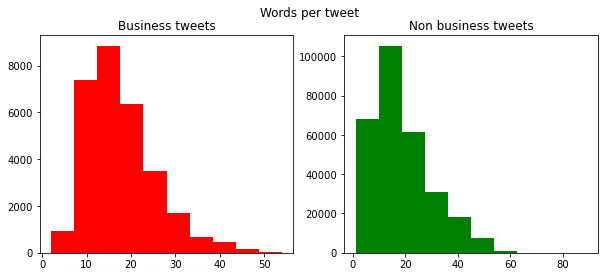

In [13]:
# Plotting word count of both classes

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
bus_words=data_1[data_1['target']==1]['word_count']
ax1.hist(bus_words,color='red')
ax1.set_title('Business tweets')
nbus_words=data_1[data_1['target']==0]['word_count']
ax2.hist(nbus_words,color='green')
ax2.set_title('Non business tweets')
fig.suptitle('Words per tweet')
plt.show()

#### Character count of the tweets

In [14]:
data_1['char_count'] = data_1['text'].apply(lambda x: len(str(x)))
print('Average character count in Business tweets:',data_1[data_1['target']==1]['char_count'].mean()) 
print('Average character count in Non-business tweets:', data_1[data_1['target']==0]['char_count'].mean()) #Non-Business tweets

Average character count in Business tweets: 125.59405808686384
Average character count in Non-business tweets: 132.5709217431764


The average word and character count of business related tweets are smaller than the non-business related tweets. Let's look at the box plot of the character count of the tweets. 

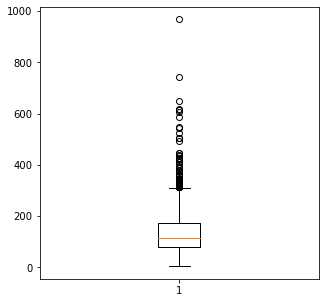

In [15]:
# Box plot of the character counts

fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data_1.char_count)
plt.show()

As we can see from above results of character count, there are numerous outliers. Although the tweets have a limit of 280 characters, we can see there are many tweets with higher character counts. It is time to clean the tweet text. The below function 'text_clean' is used to remove any hyperlinks, punctuation and numbers from tweet text.

In [16]:
# Function to clean the text 
def text_clean(text) :
    text = text.lower() 
    text = re.sub(r'http\S+', '', text) 
    text = re.sub(r'([^a-zA-Z\s]+?)', ' ', text) 
    text = re.sub(' +', ' ', text)
    text_clean = ' '.join( [w for w in text.split() if len(w)>1] )
    return text_clean

In [17]:
data_1['clean_text'] = data_1['text'].apply(text_clean)

In [18]:
data_1.head()

,tweetID,crDate,edInput,editor,engages,isApproved,isEdNeed,isRT,likes,retweets,rtUsID,text,topicName,usFlwrs,usID,usName,target,word_count,char_count,clean_text
0,1070970722598707200,2018-12-07 09:18:12,1,5001,5137,True,True,False,4180,957,-1,Which one would you choose? 👀 https://t.co/U0s...,Fashion,37293,1061553474918342656,Gentleman’s style,0,7,53,which one would you choose
1,1070981773616648193,2018-12-07 10:02:07,1,5003,52650,True,True,True,36349,16301,781427301472874497,How it’s made. 😊 https://t.co/3XjOw4gIkg,Interesting,34897,994950431234080768,Satisfying Slime,0,5,40,how it made
2,916500037818916866,2017-10-07 03:06:51,2,5003,63872,False,True,True,39698,24174,821811651393495040,"Smile, because it confuses people. Smile, beca...",Interesting,966840,482658470,Tips & Tricks Ideas ✌,0,17,129,smile because it confuses people smile because...
3,1071135340696625152,2018-12-07 20:12:20,1,5001,1714,True,True,False,1261,453,-1,𝐶𝑙𝑎𝑢𝑑𝑒 𝑀𝑜𝑛𝑒𝑡 https://t.co/WdavWJcSyw,Art,33308,762649146,𝐴𝑟𝑡.,0,3,36,
4,1071141175606829056,2018-12-07 20:35:31,1,5001,62062,True,True,False,49073,12989,-1,Baby Alpacas are so under appreciated. https:/...,Animal,1052924,2828212668,Nature is Amazing ☘️,0,7,62,baby alpacas are so under appreciated


### Vectorization

After the initial cleaning of the text, we move on to the next step of converting this text data into a format that can fed to the Machine learning algorithms, this process is called vectorization. Before moving to vectorization, let's calculate the size of the vocabulary.

In [20]:
vocab = []
for doc in data_1.clean_text:
    for word in doc.split():
        if word not in vocab:
            vocab.append(word)

In [22]:
print('Size of Vocabulary :', len(vocab))

Size of Vocaubulary : 122777


The size of vocabulary (unique words) of the dataset is 122777. If we use bag of words for vectorization we will end up with a 322381 (no. of documents) x 122777 sparse matrix as shown below. This will increase computational cose and limiting the size of vocabulary results in loss of information. Hence for these reasons, TFIDF is implemented for vectorization.

#### Count Vectorization

In [24]:
cvec = CountVectorizer()
cvec.fit(data_1.clean_text)
cvec.transform(data_1.clean_text)

<322318x122777 sparse matrix of type '<class 'numpy.int64'>'
	with 4817910 stored elements in Compressed Sparse Row format>

#### TFIDF vectorization

In [54]:
# Splitting data into train and test

X = data_1['clean_text']
y = data_1['target']

X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, stratify=y)

In [55]:
#Tf-Idf

tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

### Baseline model

I have used Logistic Regression as the baseline model because of its simplicity, it is also linear and scalable to large data. Given the data is highly imbalanced 'accuracy' alone is not a good measure of performance. Hence other metrics such as precision, recall and confusion matrix are used to evaluate the model function.

In [32]:
# Function for logistic regression and performance metrics

def log_reg (X_train_vec, y_train, X_test_vec, y_test):
    lr_tfidf=LogisticRegression(solver = 'sag', penalty='l2')
    lr_tfidf.fit(X_train_vec, y_train) 

    #Predict y value for test dataset
    y_predict = lr_tfidf.predict(X_test_vec)
    y_prob = lr_tfidf.predict_proba(X_test_vec)[:,1]

    print(classification_report(y_test,y_predict))
    print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))
 
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print('\nAUC:', roc_auc)

In [33]:
log_reg(X_train_vectors_tfidf, y_train, X_test_vectors_tfidf, y_test)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     58459
           1       0.74      0.33      0.46      6005

    accuracy                           0.93     64464
   macro avg       0.84      0.66      0.71     64464
weighted avg       0.92      0.93      0.91     64464

Confusion Matrix:
 [[57771   688]
 [ 4005  2000]]

AUC: 0.9245317088448406


The model predicts the majority class(0) with great accuracy, as expected but does not very well in predicting the minority class (1), as seen by the precision and recall scores for the minority class. 

### Factors affecting the model performance

The affect of different factors such as stopwords, n-grams, stemming and lemmatization on the performance of the base model is evaluated.

In [63]:
# Functions to caluculate accuracy wrt performance factors

def accu_summ(pipeline, X_train, y_train, X_test, y_test):
    accu_fit = pipeline.fit(X_train, y_train)
    y_pred = accu_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    #print(classification_report(y_test,y_pred))
    return accuracy 

tfidf = TfidfVectorizer(use_idf=True)
lr = LogisticRegression(solver = 'sag', penalty='l2', max_iter=1000)
n_features = np.arange(10000,150000,10000)


def nfeat_accu_finder(vectorizer=tfidf, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        finder_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', classifier)])
       # print("Performance metrics {} features".format(n))
        nfeature_accuracy = accu_summ(finder_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

#### Stopwords

First we will look at how the inclusion and removal of stopwords affect the accuracy/performance of the model. 

In [64]:
# Feature analysis with stopwords removal
stpwrds = stopwords.words('english')
feat_wosw = nfeat_accu_finder(stop_words=stpwrds)

In [65]:
# Feature analysis with stopwords
feat_wsw = nfeat_accu_finder()

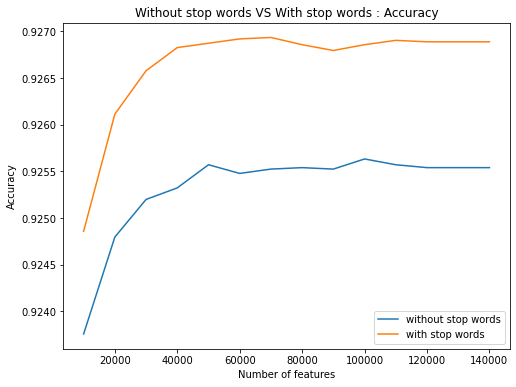

In [66]:
nfeat_plot_wosw = pd.DataFrame(feat_wosw,columns=['nfeat','val_accu'])
nfeat_plot_wsw = pd.DataFrame(feat_sw,columns=['nfeat','val_accu'])
plt.figure(figsize=(8,6))
plt.plot(nfeat_plot_wosw.nfeat, nfeat_plot_wosw.val_accu, label='without stop words')
plt.plot(nfeat_plot_wsw.nfeat, nfeat_plot_wsw.val_accu,label='with stop words')
plt.title("Without stop words VS With stop words : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")
plt.legend();

The accuracy marginally improved when the stopwords are not removed.

#### n-gram 

In the previous section the analysis was performed with unigram, in this section the performance of the model is calculated for bigram and trigram.

In [67]:
feat_bg = nfeat_accu_finder(ngram_range=(1, 2))

In [68]:
feat_tg = nfeat_accu_finder(ngram_range=(1, 3)) 

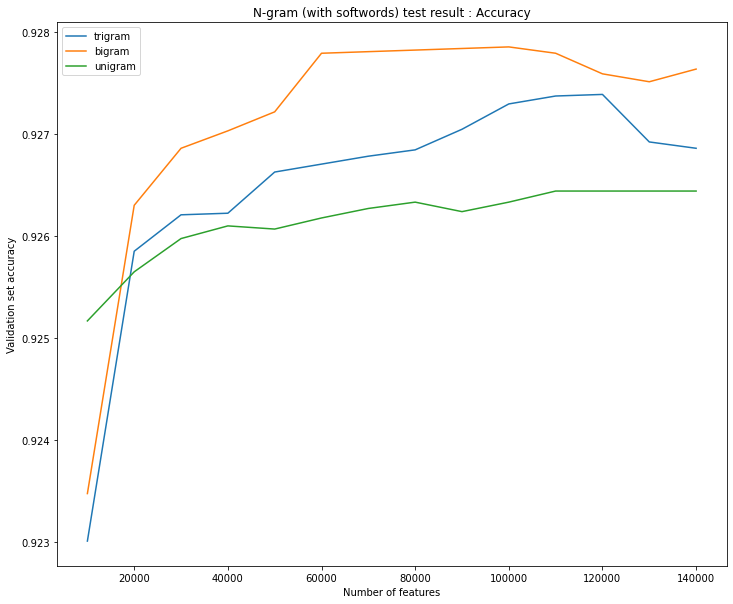

In [75]:
nfeat_plot_tg = pd.DataFrame(feat_tg,columns=['nfeat','val_accu'])
nfeat_plot_bg = pd.DataFrame(feat_bg,columns=['nfeat','val_accu'])
nfeat_plot_ug = pd.DataFrame(feat_wsw,columns=['nfeat','val_accu'])
plt.figure(figsize=(12,10))
plt.plot(nfeat_plot_tg.nfeat, nfeat_plot_tg.val_accu,label='trigram')
plt.plot(nfeat_plot_bg.nfeat, nfeat_plot_bg.val_accu,label='bigram')
plt.plot(nfeat_plot_ug.nfeat, nfeat_plot_ug.val_accu, label='unigram')

plt.title("N-gram (with softwords) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend();

The bigram sequence of data for tfidf gives better accuracy compared to unigram and trigram

#### Stemming

In [70]:
stemmer = SnowballStemmer("english")

def stem(text):
    words = text.split()
    stems = [stemmer.stem(t) for t in words]
    return " ".join(stems)

In [71]:
data_1['text_stem'] = data_1.clean_text.apply(stem)

In [72]:
X_stem, y_stem = data_1['text_stem'], data_1['target']
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y_stem , test_size=0.2, stratify=y_stem)

In [73]:
stem_vect = TfidfVectorizer(use_idf=True)
X_train_vec_stem = stem_vect.fit_transform(X_train_stem) 
X_test_vec_stem = stem_vect.transform(X_test_stem)

In [74]:
log_reg(X_train_vec_stem, y_train_stem, X_test_vec_stem, y_test_stem)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     58459
           1       0.73      0.33      0.45      6005

    accuracy                           0.93     64464
   macro avg       0.83      0.66      0.71     64464
weighted avg       0.92      0.93      0.91     64464

Confusion Matrix:
 [[57712   747]
 [ 4033  1972]]

AUC: 0.9175413331167617


There is no remarkable improvement in the performance metrics with stemming 

#### Lemmatization

In [76]:
wl = WordNetLemmatizer()

# Function to map NTLK position tags
def wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
def lemma(text):
    words = text.split()
    word_pos_tags = nltk.pos_tag(words) 
    a=[wl.lemmatize(tag[0], wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] 
    return " ".join(a)

In [77]:
data_1['text_lemm'] = data_1.clean_text.apply(lemma)

In [78]:
X_lem, y_lem = data_1['text_lemm'], data_1['target']
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem,y_lem , test_size=0.2, stratify=y_lem)

In [79]:
lemm_vect = TfidfVectorizer(use_idf=True)
X_train_vectors_lemm = lemm_vect.fit_transform(X_train_lem) 
X_test_vectors_lemm = lemm_vect.transform(X_test_lem)

In [80]:
log_reg(X_train_vectors_lemm, y_train_lem, X_test_vectors_lemm, y_test_lem)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     58459
           1       0.73      0.33      0.45      6005

    accuracy                           0.93     64464
   macro avg       0.83      0.66      0.71     64464
weighted avg       0.92      0.93      0.91     64464

Confusion Matrix:
 [[57727   732]
 [ 4043  1962]]

AUC: 0.9213818251521497


Lemmatization of the words of the data also does not improve the performance of the model compared to baseline model. 

### Sampling

Sampling is appied to the input data to overcome the effects of the class imbalance. Two oversampling techniques, Randon oversampling and SMOTE oversampling are applied to the data. In the next step Random undersampling is applied. The results of all these techniques are compared using the performance metrics. 

In [105]:
def sampling (X_train, y_train, X_test, y_test, pipeline):
    
    pipe_samp = pipeline.fit(X_train, y_train)
   

    #Predict y value for test dataset
    y_predict =  pipe_samp.predict(X_test) 
    y_prob = pipe_samp.predict_proba(X_test)[:,1]

    print(classification_report(y_test,y_predict))
    print('Confusion Matrix:\n',confusion_matrix(y_test, y_predict))
 
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print('\nAUC:', roc_auc)

In [87]:
X_samp, y_samp = data_1['text_lemm'], data_1['target']
X_train_samp, X_test_samp, y_train_samp, y_test_samp = train_test_split(X_lem,y_lem , test_size=0.2, stratify=y_samp)

In [88]:
tfidf_samp= TfidfVectorizer(use_idf=True)

In [89]:
lr_samp=LogisticRegression(solver = 'sag', C=10, penalty='l2')

#### Oversampling

In [103]:
# Random Over Sampling pipeline
ROS_pipeline = make_pipeline(tfidf_samp, RandomOverSampler(random_state=777),lr_samp)

# Synthetic Minority Oversampling Technique (SMOTE) Over Sampling pipeline
SMOTE_pipeline = make_pipeline(tfidf_samp, SMOTE(random_state=777), lr_samp)

In [107]:
sampling(X_train_samp, y_train_samp, X_test_samp, y_test_samp, ROS_pipeline)

              precision    recall  f1-score   support

           0       0.98      0.90      0.93     58459
           1       0.43      0.78      0.56      6005

    accuracy                           0.88     64464
   macro avg       0.70      0.84      0.75     64464
weighted avg       0.92      0.88      0.90     64464

Confusion Matrix:
 [[52322  6137]
 [ 1314  4691]]

AUC: 0.9216439045454105


In [100]:
#SMOTE Oversampling
sampling(X_train_samp, y_train_samp, X_test_samp, y_test_samp, SMOTE_pipeline)

              precision    recall  f1-score   support

           0       0.97      0.90      0.94     58459
           1       0.44      0.76      0.56      6005

    accuracy                           0.89     64464
   macro avg       0.71      0.83      0.75     64464
weighted avg       0.92      0.89      0.90     64464

Confusion Matrix:
 [[52715  5744]
 [ 1413  4592]]

AUC: 0.9196222680544172


#### Undersampling

In [101]:
# Random Under Sampling pipeline
RUS_pipeline = make_pipeline(tfidf_samp, RandomUnderSampler(random_state=777),lr_samp)

In [102]:
sampling(X_train_samp, y_train_samp, X_test_samp, y_test_samp, RUS_pipeline)

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     58459
           1       0.34      0.85      0.49      6005

    accuracy                           0.83     64464
   macro avg       0.66      0.84      0.70     64464
weighted avg       0.92      0.83      0.86     64464

Confusion Matrix:
 [[48714  9745]
 [  912  5093]]

AUC: 0.9149105533217492


Sampling (both over and under) flipped the results from baseline model for hte minority class. Without any sampling, for baseline model we have high precision and low recall. With sampling, we have high recall but low precision. The model is trained to predict more positive results but they are not true positives. Although recall and precision numbers for all the three results are similar, SMOTE sampling gives the highest accuracy. Due to this reason, SMOTE sampling is chosen for the analysis.

### Modeling

Apart from the logistic regression as baseline classifier, two other classifiers, Random forest classifier and Extreme gradient boosting classifiers are applied in the next section. The performance of these models is evaluated on the sampled data and results are compared. 

#### Sampling - SMOTE

In [108]:
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_resample(X_train_vectors_tfidf, y_train)
print(X_train_smote.shape, y_train_smote.shape)

smote = SMOTE()
X_test_smote, y_test_smote = smote.fit_resample(X_test_vectors_tfidf, y_test)
print(X_test_smote.shape, y_test_smote.shape)


(467670, 110856) (467670,)
(116918, 110856) (116918,)


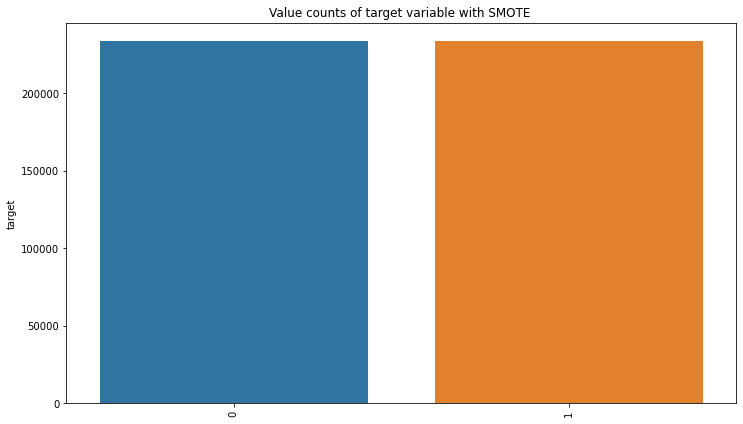

In [109]:
# Plotting the sampled data
tar_smote = pd.value_counts(y_train_smote)
plt.figure(figsize = (12, 7))
plt.title('Value counts of target variable with SMOTE ')
sns.barplot(x=tar_smote.index, y=tar_smote)
plt.xticks(rotation=90);

#### Random Forest Classifier

In [110]:
rfc = RandomForestClassifier()

In [112]:
rfc.fit(X_train_smote, y_train_smote)

RandomForestClassifier()

In [113]:
rfc_predict = rfc.predict(X_test_smote)
y_prob_smote = rfc.predict_proba(X_test_smote)[:,1]


print(classification_report(y_test_smote,rfc_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test_smote, rfc_predict))
 
fpr, tpr, thresholds = roc_curve(y_test_smote, y_prob_smote)
roc_auc = auc(fpr, tpr)
print('\nAUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.84      0.98      0.90     58459
           1       0.97      0.81      0.88     58459

    accuracy                           0.89    116918
   macro avg       0.91      0.89      0.89    116918
weighted avg       0.91      0.89      0.89    116918

Confusion Matrix:
 [[57194  1265]
 [11166 47293]]

AUC: 0.978580076304456


#### Extreme Gradient Boosting Classifier 

In [114]:
xgboost = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')
xgboost.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=None, ...)

In [116]:
xgb_predict = xgboost.predict(X_test_smote)
y_xgb_prob_smote = xgboost.predict_proba(X_test_smote)[:,1]


print(classification_report(y_test_smote,xgb_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test_smote, xgb_predict))
 
fpr, tpr, thresholds = roc_curve(y_test_smote, y_xgb_prob_smote)
roc_auc = auc(fpr, tpr)
print('\nAUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.87      0.97      0.92     58459
           1       0.97      0.85      0.91     58459

    accuracy                           0.91    116918
   macro avg       0.92      0.91      0.91    116918
weighted avg       0.92      0.91      0.91    116918

Confusion Matrix:
 [[56904  1555]
 [ 8530 49929]]

AUC: 0.9730031201253551


There is a remarkable improvement in the recall and precision with both random forest and xgboost models compared to baseline model. However, xgboost model has higher recall and accuracy compared to random forest. Moreover, xgboost is computationally much faster than random forest. Because of these reasons, xgboost is chosen over random forest. 

### Hyperparameter tuning

Given the complexity of xgboost and the size of the data, hyperparameter tuning of xgboost using GridsearchCV was running into multiple hours. For this reason, Randomized search CV is used for hyperparameter tuning.

In [118]:
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.2, stratify=y) 

In [119]:
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)

In [120]:
# SMOTE for the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_vectors_tfidf, y_train)

In [121]:
# SMOTE for the testing data
X_test_smote, y_test_smote = smote.fit_resample(X_test_vectors_tfidf, y_test)

In [123]:
classifier = xgb.XGBClassifier()

In [127]:
params = { 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30], 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ], 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
}

In [128]:
rs_model=RandomizedSearchCV(classifier,param_distributions=params,
                            n_iter=5,scoring='accuracy',n_jobs=-1,cv=5,verbose=3)

In [129]:
rs_model.fit(X_train_smote,y_train_smote)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           monotone_constraints=None,
                         

[CV 1/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=3;, score=0.736 total time= 3.6min
[CV 1/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.25, max_depth=12, min_child_weight=5;, score=0.759 total time= 4.7min
[CV 4/5] END colsample_bytree=0.4, gamma=0.1, learning_rate=0.1, max_depth=8, min_child_weight=1;, score=0.924 total time= 3.5min
[CV 3/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.3, max_depth=3, min_child_weight=5;, score=0.918 total time= 1.6min
[CV 2/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=3;, score=0.934 total time= 3.5min
[CV 4/5] END colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=12, min_child_weight=3;, score=0.937 total time= 3.7min
[CV 3/5] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.25, max_depth=12, min_child_weight=5;, score=0.953 total time= 4.6min
[CV 5/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.3, max_depth=3, min_c

In [130]:
rs_model.best_estimator_

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [133]:
rs_predict = rs_model.predict(X_test_smote)
y_rs_prob = rs_model.predict_proba(X_test_smote)[:,1]

In [135]:
print(classification_report(y_test_smote,rs_predict))
print('Confusion Matrix:\n',confusion_matrix(y_test_smote, rs_predict))
 
fpr, tpr, thresholds = roc_curve(y_test_smote, y_xgb_prob_smote)
roc_auc = auc(fpr, tpr)
print('\nAUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     58459
           1       0.97      0.88      0.92     58459

    accuracy                           0.93    116918
   macro avg       0.93      0.93      0.93    116918
weighted avg       0.93      0.93      0.93    116918

Confusion Matrix:
 [[57011  1448]
 [ 7113 51346]]

AUC: 0.9340624192464602


Hyperparameter tuning utilizing Randomized search CV yields improvement both in terms of recall and accuracy of the xgboost classifier.

### Conclusions

A working classification model is developed to classify twitter data into 'Business' and 'Non-business' categories. The tweets data is cleaned and the affect of factors such as, stopwords, stemming and lemmatization are studied using logistic regression as a baseline classifier. As the data was heavily imbalanced various techniques such as random oversampling, SMOTE oversampling and random undersampling to overcome the imbalance. The performance of the baseline classifier is compared for all the sampling techniques. Based on the results it is deduced that SMOTE is the best sampling choice. Apart from the accuracy score, precision, recall, confusion matrix and AUC are used as metrics to evaluate the models. More robust models such as Random forest classifier and Extreme gradient boosting classifier models are built for classifying the twitter data. Owing to the oversampling of data and to the ensembling nature of these models, there was a remarkable improvement in the recall and precision metrics for both the models. However, in terms of computational speed, xgboost was much faster compared to random forest classifier without compromising the performance. Hence xgboost is chosen as the best of the two models for classifying hte twitter data. The model parameters are further enhanced using randomized seatch CV for hyperparameter tuning. This further improved the performance of the model. 